In [1]:
#Diabetic Retinopathy
# Dataset - https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data

"""
Improving loss function, using a loss function that is quadratic - so correlates well with cohens kappa
"""

'\nImproving loss function, using a loss function that is quadratic - so correlates well with cohens kappa\n'

### Imports

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split as datasetSplit
import numpy as np 
import os

import torch
import torch.nn as nn
import torchvision 
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

from torch.optim import lr_scheduler


### Hyperparameters

In [3]:
# Dataset paths containing all the images and image labels
dataset_images = "Data/images_650_V2/"
dataset_labels = "Data/trainLabels.csv"

BATCHSIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0005 #L2 Norm on the model weights
NUM_EPOCHS = 100
NUM_WORKERS = 0 
CHECKPOINT_FOLDER = "Checkpoints/"
CHECKPOINT_FILE = "EfNetB3_v3.pth.tar" #Experiment 3 
PATIENCE = 4 #for early stopping

PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

INPUT_IMAGE_WIDTH = 120
INPUT_IMAGE_HEIGHT = 120

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/EfNetB3_v3")

### Dataset

In [4]:
print(f'{len(os.listdir(dataset_images))} images found in the dataset_images') 

35126 images found in the dataset_images


#### Train Val Split

In [5]:
inputs = np.array(pd.read_csv(dataset_labels)["image"])
targets = np.array(pd.read_csv(dataset_labels)["level"])
print(f"{len(inputs)} images and {len(targets)} targets found")

35126 images and 35126 targets found


In [6]:
train_inputs, val_inputs, train_labels, val_labels = datasetSplit(inputs,targets,test_size= 0.11,random_state=47,shuffle=True)

In [7]:
print(f"Dataset Train Size: {len(train_inputs)}, Dataset Test Size:{len(val_inputs)}")

Dataset Train Size: 31262, Dataset Test Size:3864


#### Dataset Class

In [8]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self,inputs,targets,data_transforms=None):
        self.inputs = inputs
        self.targets = torch.from_numpy(targets.astype(np.float32))
        self.data_transforms = data_transforms
        self.n_samples = len(inputs)
        
    def __getitem__(self,index):
        img_path = self.inputs[index]
        img = Image.open(dataset_images+img_path+".jpeg")
        img = np.array(img) #Albumenations takes nd.array as input
        # img = torch.from_numpy(img.astype(np.float32))
        img_label = self.targets[index]
        if self.data_transforms:
            img = self.data_transforms(image=img)["image"]
            img.type(torch.float32)
        return img, img_label, img_path
        
    def __len__(self):
        return self.n_samples


#### Data Transforms

In [9]:
train_transforms = A.Compose([
    A.Resize(width=INPUT_IMAGE_WIDTH+7,height=INPUT_IMAGE_HEIGHT+7),
    A.RandomCrop(width=INPUT_IMAGE_WIDTH,height=INPUT_IMAGE_HEIGHT),
    A.Normalize(mean=[0.3199, 0.2240, 0.1609],std=[0.3020, 0.2183, 0.1741],max_pixel_value = 255.0), 
    ToTensorV2()
    ])

#Test with more transformations

val_transforms = A.Compose([
    A.Resize(width=INPUT_IMAGE_WIDTH,height=INPUT_IMAGE_HEIGHT),
    A.Normalize(mean=[0.3199, 0.2240, 0.1609],std=[0.3020, 0.2183, 0.1741],max_pixel_value = 255.0), 
    ToTensorV2()
    ])

#### Dataset Loader

In [10]:
train_dataset = DiabeticRetinopathyDataset(train_inputs,train_labels,data_transforms=train_transforms)
val_dataset = DiabeticRetinopathyDataset(val_inputs,val_labels,data_transforms=val_transforms)

In [11]:
train_loader =DataLoader(train_dataset,batch_size=BATCHSIZE,shuffle=True,num_workers=NUM_WORKERS)
val_loader =DataLoader(val_dataset,batch_size=BATCHSIZE,shuffle=False,num_workers=NUM_WORKERS)

#### Having a look at first batch

In [12]:
train_iter = iter(train_loader)
first_batch = train_iter.next()
batch_images, batch_labels, batch_files = first_batch

In [13]:
batch_images.shape

torch.Size([64, 3, 120, 120])

In [14]:
batch_labels.shape

torch.Size([64])

##### Visualise Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


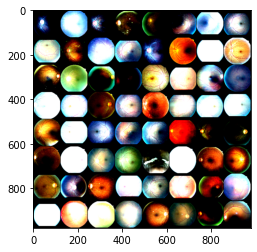

In [15]:
batch_images_grid = torchvision.utils.make_grid(batch_images,nrow=8)
writer.add_image("Retina Images",batch_images_grid)
writer.close()

plt.imshow(batch_images_grid.permute(1, 2, 0))

### Utility Functions

In [16]:
def make_prediction(model,dataloader,output_csv="submission.csv"):
    all_preds = []
    file_names = []
    # total_loss = 0.0
    model.eval() #set the model to evaluation state

    for inputs, labels, names in enumerate(dataloader):
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            outs = model(inputs)

            # _, batch_preds = torch.max(outs,1)
            
            preds = outs
            preds[preds < 0.5] = 0
            preds[(preds >= 0.5) & (preds < 1.5)] = 1
            preds[(preds >= 1.5) & (preds < 2.5)] = 2
            preds[(preds >= 2.5) & (preds < 3.5)] = 3
            preds[preds >= 3.5] = 4
            preds = preds.long().squeeze(1)

            batch_preds = preds
            all_preds.append(batch_preds.cpu().numpy())
            file_names.append(names)

    df = pd.DataFrame({"image":file_names,"level":np.concatenate(all_preds, axis=0)})
    df.to_csv(output_csv,index=False)
    model.train() #Set the model back to training phase

def calculate_accuracy(model,dataloader,epoch_num):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [],[]
    correct_predictions = 0
    num_samples = 0
    dataiter = tqdm(dataloader)
    for batchID, (inputs, labels, names) in enumerate(dataiter):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outs = model(inputs)

            # _, batch_preds = torch.max(outs,1)

            preds = outs
            preds[preds < 0.5] = 0
            preds[(preds >= 0.5) & (preds < 1.5)] = 1
            preds[(preds >= 1.5) & (preds < 2.5)] = 2
            preds[(preds >= 2.5) & (preds < 3.5)] = 3
            preds[preds >= 3.5] = 4
            batch_preds = preds.long().view(-1)
            labels_ = labels.view(-1)


            
            batch_loss = loss_func(outs,labels)
            
           
            correct_predictions += (batch_preds==labels_).sum().item()
            num_samples += outs.shape[0]

            all_preds.append(batch_preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            total_loss += batch_loss.item()
        dataiter.set_postfix(loss=batch_loss.item())
            
            

    model.train()
    epoch_acc = 100.0*correct_predictions/num_samples
    epoch_loss = total_loss/len(dataloader)
    # print(f"Epoch Accuracy: {accuracy:.2f}%. Predicted {correct_predictions} correcctly out of {num_samples} images!")
    all_preds = np.concatenate(all_preds,axis=0,dtype=np.int64)
    all_labels = np.concatenate(all_labels,axis=0,dtype=np.int64)
    kappa = cohen_kappa_score(all_labels,all_preds,weights='quadratic')
    print(f"Epoch (Val): {epoch_num}, Loss= {epoch_loss}, Accuracy= {epoch_acc}, Kappa= {kappa}")
    writer.add_scalar('val_loss',epoch_loss,global_step=epoch_num)
    writer.add_scalar('val_acc',epoch_acc,global_step=epoch_num)
    writer.add_scalar('val_kappa',kappa,global_step=epoch_num)
    writer.close()
    return epoch_acc, kappa 

            
def save_checkpoint(state_dicts):
    torch.save(state_dicts,CHECKPOINT_FOLDER+CHECKPOINT_FILE)

def load_checkpoint(checkpoint_file,model,optimiser,learning_rate):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["state_dict"])
    optimiser.load_state_dict(checkpoint["optimiser"])

    for params in optimiser.param_groups:
        params["lr"] = learning_rate
    


### Design the Model

#### Model

In [17]:
model = EfficientNet.from_pretrained("efficientnet-b3")
in_features = model._fc.in_features
# model._fc = nn.Linear(in_features,1) #Use just 1 prediction, convert this float value into integer predictions
model._fc = nn.Linear(in_features,5)
model = model.to(DEVICE)

Loaded pretrained weights for efficientnet-b3


#### Loss Function, Optmiser

In [18]:
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
lr_scheduler1 = lr_scheduler.StepLR(optimiser,step_size=7,gamma=0.1)

In [19]:
load_checkpoint('Checkpoints/EfNetB3_v2_B.pth.tar',model,optimiser,LEARNING_RATE)

In [20]:
model._fc = nn.Linear(in_features,1) #Use just 1 prediction, convert this float value into integer predictions
model = model.to(DEVICE)

### Training

In [21]:
def train_epoch(model,dataloader,optimiser,scheduler,loss_func,scaler,epoch_num):
    total_loss = 0.0
    dataiter = tqdm(dataloader)
    correct_predictions = 0
    num_samples = 0
    all_preds, all_labels = [],[]
    for batch_num,(inputs,labels,filenames) in enumerate(dataiter):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)

        if batch_num%40 == 0 and epoch_num%10==0 : #visualising few batch images (after transforms) 
            writer.add_image("Batch_"+str(batch_num),torchvision.utils.make_grid(inputs,nrow=8))
            writer.close()

        #forward pass
        with torch.cuda.amp.autocast():
            outs = model(inputs)
            # _, batch_preds = torch.max(outs,1)
            
            # print(outs.shape,labels.shape) 
            batch_loss = loss_func(outs,labels.unsqueeze(1).float())

            preds = outs
            preds[preds < 0.5] = 0
            preds[(preds >= 0.5) & (preds < 1.5)] = 1
            preds[(preds >= 1.5) & (preds < 2.5)] = 2
            preds[(preds >= 2.5) & (preds < 3.5)] = 3
            preds[preds >= 3.5] = 4

            batch_preds = preds.long().view(-1)
            labels_ = labels.view(-1)




        
        total_loss += batch_loss.item()
        correct_predictions += (batch_preds==labels_).sum().item()
        num_samples += outs.shape[0]
        all_preds.append(batch_preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        #backward step
        optimiser.zero_grad()
        scaler.scale(batch_loss).backward()
        scaler.step(optimiser)
        # optimiser.step()
        scaler.update()
        dataiter.set_postfix(loss=batch_loss.item())

    epoch_loss = total_loss/len(dataloader)
    epoch_acc = 100.0*correct_predictions/num_samples
    all_preds = np.concatenate(all_preds,axis=0,dtype=np.int64)
    all_labels = np.concatenate(all_labels,axis=0,dtype=np.int64)
    scheduler.step()

    kappa = cohen_kappa_score(all_labels,all_preds,weights='quadratic')
    print(f"Epoch (Train): {epoch_num}, Loss= {epoch_loss}, Accuracy= {epoch_acc}, Kappa= {kappa}")
    writer.add_scalar('training_loss',epoch_loss,global_step=epoch_num)
    writer.add_scalar('training_acc',epoch_acc,global_step=epoch_num)
    writer.add_scalar('training_kappa',kappa,global_step=epoch_num)
    writer.close()
    

In [23]:
def trainModel(model,trainloader,valloader,optimiser,lr_scheduler1,loss_func,epochs):
    
    checkpoint_stuff = {"state_dict":model.state_dict() ,"optimiser":optimiser.state_dict()}
    best_kappa = 0.0
    best_epoch = 0
    es = 0 #early stopper

    for epoch in range(epochs):

        #Train Phase
        model.train()
        
        train_epoch(model,train_loader,optimiser,lr_scheduler1,loss_func,scaler,epoch)
        
        #Validation Phase
        model.eval()
        epoch_acc, kappa  = calculate_accuracy(model,val_loader,epoch)
        
        #Early stopping and checkpoints
        if (kappa > best_kappa) :
            best_kappa = kappa
            es = 0 
            checkpoint_stuff = {"state_dict":model.state_dict() ,"optimiser":optimiser.state_dict()}
            best_epoch = epoch
            print(f"Checkpoint Saved at {best_epoch}")
        else :
            es += 1
            print(f"Model performance has not improved in this epoch. Patience: {es}/{PATIENCE}")
            if es>PATIENCE:
                print(f"Early Stopping with {best_kappa} at Epoch {best_epoch}")
                break


    model.load_state_dict(checkpoint_stuff["state_dict"]) #load the best model
    if SAVE_MODEL:
        save_checkpoint(checkpoint_stuff)
        # print("Checkpoint - Model Saved at {best_epoch}")
    return model #return the trained model
    
    




In [24]:
trainedModel = trainModel(model,train_loader,val_loader,optimiser,lr_scheduler1,loss_func,40)

100%|██████████| 489/489 [04:51<00:00,  1.68it/s, loss=0.412] 


Epoch (Train): 0, Loss= 0.26660310787840125, Accuracy= 79.83814215341309, Kappa= 0.8318386041408425


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:29<00:00,  2.07it/s, loss=1.11] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:29<00:00,  2.09it/s, loss=3.38]


Epoch (Val): 0, Loss= 1.5667824667008197, Accuracy= 66.51138716356108, Kappa= 0.5778518683603471
Checkpoint Saved at 0


100%|██████████| 489/489 [04:40<00:00,  1.75it/s, loss=0.0868]


Epoch (Train): 1, Loss= 0.17663988021558535, Accuracy= 84.4027893288977, Kappa= 0.8889122708604313


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:28<00:00,  2.20it/s, loss=1.14] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.16it/s, loss=3.21]


Epoch (Val): 1, Loss= 1.5432382372559095, Accuracy= 67.59834368530021, Kappa= 0.5729080470245147
Model performance has not improved in this epoch. Patience: 1/4


100%|██████████| 489/489 [04:43<00:00,  1.73it/s, loss=0.172] 


Epoch (Train): 2, Loss= 0.1586338958278268, Accuracy= 86.12692725993219, Kappa= 0.9016028144640269


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:28<00:00,  2.14it/s, loss=1.17] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.15it/s, loss=3.21]


Epoch (Val): 2, Loss= 1.6672296563132865, Accuracy= 67.49482401656314, Kappa= 0.5954176153439061
Checkpoint Saved at 2


100%|██████████| 489/489 [04:40<00:00,  1.74it/s, loss=0.314] 


Epoch (Train): 3, Loss= 0.14750472204816853, Accuracy= 86.913825091165, Kappa= 0.9095494341282786


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.17it/s, loss=1.26] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.23it/s, loss=3.4] 


Epoch (Val): 3, Loss= 1.6994001865386963, Accuracy= 68.63354037267081, Kappa= 0.6098630540915193
Checkpoint Saved at 3


100%|██████████| 489/489 [04:34<00:00,  1.78it/s, loss=0.422] 


Epoch (Train): 4, Loss= 0.1395058617574793, Accuracy= 87.8190774742499, Kappa= 0.9149628026010627


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.16it/s, loss=1.36] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.22it/s, loss=3.18]


Epoch (Val): 4, Loss= 1.7397754426862373, Accuracy= 68.2712215320911, Kappa= 0.6152014145677204
Checkpoint Saved at 4


100%|██████████| 489/489 [04:34<00:00,  1.78it/s, loss=0.0621]


Epoch (Train): 5, Loss= 0.12710125494466482, Accuracy= 88.35966988676348, Kappa= 0.9223290866630314


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.22it/s, loss=1.21] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.20it/s, loss=3.35]


Epoch (Val): 5, Loss= 1.6556443190965495, Accuracy= 67.2360248447205, Kappa= 0.6024832769295198
Model performance has not improved in this epoch. Patience: 1/4


100%|██████████| 489/489 [04:40<00:00,  1.74it/s, loss=0.66]  


Epoch (Train): 6, Loss= 0.13064277722883078, Accuracy= 88.31168831168831, Kappa= 0.9200808663214538


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.22it/s, loss=1.33] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.23it/s, loss=3.26]


Epoch (Val): 6, Loss= 1.6519862120268776, Accuracy= 68.76293995859213, Kappa= 0.6127710304565785
Model performance has not improved in this epoch. Patience: 2/4


100%|██████████| 489/489 [04:43<00:00,  1.73it/s, loss=0.0403]


Epoch (Train): 7, Loss= 0.09550017313860311, Accuracy= 90.9826626575395, Kappa= 0.9434309574988597


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:29<00:00,  1.97it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:30<00:00,  2.03it/s, loss=3.26]


Epoch (Val): 7, Loss= 1.656548840100648, Accuracy= 70.23809523809524, Kappa= 0.6304349579944746
Checkpoint Saved at 7


100%|██████████| 489/489 [04:39<00:00,  1.75it/s, loss=0.0878]


Epoch (Train): 8, Loss= 0.07737631012889383, Accuracy= 92.71319813191734, Kappa= 0.9549113946113034


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.21it/s, loss=1.29] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.23it/s, loss=3.46]


Epoch (Val): 8, Loss= 1.6673737393050898, Accuracy= 70.1086956521739, Kappa= 0.628673885885096
Model performance has not improved in this epoch. Patience: 1/4


100%|██████████| 489/489 [04:45<00:00,  1.71it/s, loss=0.0361]


Epoch (Train): 9, Loss= 0.06809514859626507, Accuracy= 93.56727016825539, Kappa= 0.9610181774772883


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:28<00:00,  2.26it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.16it/s, loss=3.41]


Epoch (Val): 9, Loss= 1.6794633709016393, Accuracy= 70.08281573498965, Kappa= 0.6336814300872514
Checkpoint Saved at 9


100%|██████████| 489/489 [04:49<00:00,  1.69it/s, loss=0.228] 


Epoch (Train): 10, Loss= 0.06683887613285905, Accuracy= 93.74000383852601, Kappa= 0.962847164483418


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.17it/s, loss=1.33] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.18it/s, loss=3.51]


Epoch (Val): 10, Loss= 1.683708484055566, Accuracy= 69.87577639751552, Kappa= 0.6352314214981042
Checkpoint Saved at 10


100%|██████████| 489/489 [04:39<00:00,  1.75it/s, loss=0.0341]


Epoch (Train): 11, Loss= 0.06016940068918259, Accuracy= 94.30618642441303, Kappa= 0.9665856290868369


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:28<00:00,  2.19it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.14it/s, loss=3.51]


Epoch (Val): 11, Loss= 1.6849491987072054, Accuracy= 70.4192546583851, Kappa= 0.6349340082831427
Model performance has not improved in this epoch. Patience: 1/4


100%|██████████| 489/489 [04:39<00:00,  1.75it/s, loss=0.0472]


Epoch (Train): 12, Loss= 0.05912890075753559, Accuracy= 94.4405348346235, Kappa= 0.9674329320955293


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.19it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:28<00:00,  2.17it/s, loss=3.51]


Epoch (Val): 12, Loss= 1.6846130050596644, Accuracy= 69.97929606625259, Kappa= 0.6317225989048909
Model performance has not improved in this epoch. Patience: 2/4


100%|██████████| 489/489 [04:39<00:00,  1.75it/s, loss=0.0334]


Epoch (Train): 13, Loss= 0.055968031153875136, Accuracy= 94.84358006525494, Kappa= 0.9693916051068523


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.25it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=3.51]


Epoch (Val): 13, Loss= 1.6859577796498284, Accuracy= 69.7463768115942, Kappa= 0.6331676364032429
Model performance has not improved in this epoch. Patience: 3/4


100%|██████████| 489/489 [04:38<00:00,  1.75it/s, loss=0.0779]


Epoch (Train): 14, Loss= 0.052580285825002904, Accuracy= 95.09628302731751, Kappa= 0.971976783351358


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.21it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=3.51]


Epoch (Val): 14, Loss= 1.6849091756539267, Accuracy= 70.08281573498965, Kappa= 0.6367928073134999
Checkpoint Saved at 14


100%|██████████| 489/489 [04:38<00:00,  1.76it/s, loss=0.101] 


Epoch (Train): 15, Loss= 0.051628112402536994, Accuracy= 95.20824003582624, Kappa= 0.9725460944483955


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.19it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.18it/s, loss=3.51]


Epoch (Val): 15, Loss= 1.679986340100648, Accuracy= 69.97929606625259, Kappa= 0.6334696707503591
Model performance has not improved in this epoch. Patience: 1/4


100%|██████████| 489/489 [04:38<00:00,  1.76it/s, loss=0.0331]


Epoch (Train): 16, Loss= 0.05083895048435114, Accuracy= 95.41616019448531, Kappa= 0.9734882435457326


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.15it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=3.41]


Epoch (Val): 16, Loss= 1.6840340035860655, Accuracy= 69.77225672877847, Kappa= 0.6308873392617235
Model performance has not improved in this epoch. Patience: 2/4


100%|██████████| 489/489 [04:38<00:00,  1.76it/s, loss=0.0349]


Epoch (Train): 17, Loss= 0.05176692255077491, Accuracy= 95.39696756445525, Kappa= 0.9731789973012407


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.20it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=3.41]


Epoch (Val): 17, Loss= 1.6761654713114753, Accuracy= 70.2639751552795, Kappa= 0.6349410938059048
Model performance has not improved in this epoch. Patience: 3/4


100%|██████████| 489/489 [04:38<00:00,  1.75it/s, loss=0.157] 


Epoch (Train): 18, Loss= 0.051885495859375394, Accuracy= 95.32019704433498, Kappa= 0.9728335599439611


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.25it/s, loss=1.29] C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.19it/s, loss=3.46]


Epoch (Val): 18, Loss= 1.671912353546893, Accuracy= 70.44513457556936, Kappa= 0.6323422806713614
Model performance has not improved in this epoch. Patience: 4/4


100%|██████████| 489/489 [04:38<00:00,  1.75it/s, loss=0.115] 


Epoch (Train): 19, Loss= 0.049146890943081466, Accuracy= 95.48333439959056, Kappa= 0.9745337720440953


  0%|          | 0/61 [00:00<?, ?it/s]C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 60/61 [00:27<00:00,  2.18it/s, loss=1.3]  C:\Users\Abhinav Reddy Nimma\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 61/61 [00:27<00:00,  2.18it/s, loss=3.46]


Epoch (Val): 19, Loss= 1.6774835625632865, Accuracy= 70.4968944099379, Kappa= 0.6316843890397585
Model performance has not improved in this epoch. Patience: 5/4
Early Stopping with 0.6367928073134999 at Epoch 14


: 